# Import

In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os

plt.rcParams['svg.fonttype'] = 'none'


# Static

In [2]:
def tsd_zscore(tsd,axis = 0):
    from scipy.stats import zscore
    t = tsd.index.values
    q = zscore(tsd.values,axis = axis)

    return nts.TsdFrame(t,q)
     
def get_extended_sleep(states, sleep_th, wake_th):

    # Return extended sleep session given state, sleep

    ext_sleep = states['sws'].union(
        states['Rem']).merge_close_intervals(wake_th, time_units='s')
    ext_sleep = ext_sleep[ext_sleep.duration(
        time_units='s') > sleep_th].reset_index(drop=True)

    return ext_sleep


def get_extended_wake(states, wake_th, sleep_th):

    # Return extended wake session given state, sleep

    ext_wake = states['wake'].merge_close_intervals(sleep_th, time_units='s')
    ext_wake = ext_wake[ext_wake.duration(
        time_units='s') > wake_th].reset_index(drop=True)

    return ext_wake


def main(base_folder, local_path, *args, **kwargs):
    state = args[0]


    bk.load.current_session_linux(base_folder,local_path)

    states = bk.load.states()
    extsleep = get_extended_sleep(states, 60*30, 60)
    extwake = get_extended_wake(states, 60*30, 60)

    neurons, metadata = bk.load.spikes()
    t,q = bk.compute.binSpikes(neurons,1)

    q = nts.TsdFrame(t,q.T,time_units='s')

    fr = []
    for s, e in extsleep.iloc:
        current_sleep = nts.IntervalSet(s, e)
        first = states[state].intersect(current_sleep)[0:1]
        last = states[state].intersect(current_sleep)[-1:]
        print(first)

        first_duration = int(first.duration(time_units='s'))
        last_duration = int(last.duration(time_units='s'))
        
        
        
        
        # q_z = tsd_zscore(q.restrict(current_sleep))
        # mean_z_first = np.mean(q_z.restrict(first).values,axis = 0)
        # mean_z_last = np.mean(q_z.restrict(last).values,axis = 0)
        # df = {'First':mean_z_first,'Last':mean_z_last}
        # df = pd.DataFrame(df)
        # fr.append(df)
        
        n_spikes_first = np.sum(q.restrict(current_sleep).restrict(first).values,axis = 0)
        n_spikes_last = np.sum(q.restrict(current_sleep).restrict(last).values,axis = 0)


        fr_first = n_spikes_first/first_duration
        fr_last = n_spikes_last / last_duration


        df = {'First':fr_first,'Last':fr_last}
        df = pd.DataFrame(df)
            
        fr.append(df)
    
    
    # ax = plt.subplot(211)
    # bk.plot.intervals(states['Rem'])
    # bk.plot.intervals(states['sws'],'grey')
    # plt.subplot(212, sharex = ax)
    # bk.plot.intervals(extsleep,'lightblue')
    # sns.boxplot(data = df)
    # plt.title(bk.load.session)
    # plt.draw()

    return fr,metadata


def ext_sleep_length(base_folder,local_path):
    bk.load.current_session_linux(base_folder,local_path)

    states = bk.load.states()
    extsleep = get_extended_sleep(states, 60*30, 60)
    
    return extsleep.duration(time_units = 's')/60


def merge(batch, name, discard):

    df = []
    metadata = []
    for i, b in batch.items():
        if (i not in discard) and b[0]:
            df.append(np.mean(b[0], axis=0))
            metadata.append(b[1])
    df = np.vstack(df)
    df = pd.DataFrame(df, columns=['First', 'Last'])

    merged = {'name': name,
              'fr': df,
              'metadata':pd.concat(metadata)}

    merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged


def plot_firing_pre_post_sleep(merged,stru,type,ax = None):
    
    if ax is None:
        fig,ax = plt.subplots(1,1)
    
    fr = merged['fr']
    metadata = merged['metadata']
    metadata = metadata.reset_index()
    name = merged['name']
    # fr = pd.concat((fr,metadata))

    fr = fr[(metadata.Region == stru) & (metadata.Type == type)]


    plt.sca(ax)
    sns.stripplot(data = np.log10(fr),size = 2, alpha = 0.5)
    # ord = np.argsort(fr['Last'].values - fr['First'].values)
    # plt.imshow(fr.iloc[ord],aspect = 'auto',interpolation='None')
    # plt.colorbar()
    plt.ylim(-3,3)
    plt.title(f'{stru}-{type}-{name}')
    print(f'Stats on {len(fr)}')
    print(scipy.stats.wilcoxon(fr['First'],fr['Last']))
    return fr

In [10]:
batch = bk.load.batch(ext_sleep_length)
ext_len = np.array(0)
for b in batch.values():
    ext_len = np.hstack((ext_len, b))
ext_len = ext_len[1:]
print(f'Mean durations of ext sleep : {np.nanmean(ext_len)}')
print(f'Std of ext sleep: {np.std(ext_len)}')
print(f'Number of ext sleep : {len(ext_len)}')


 95%|█████████▌| 58/61 [00:03<00:00,  8.81it/s]

Loading Data from Rat11-20150401


NREM Hpc


NameError: name 'merged_sws' is not defined

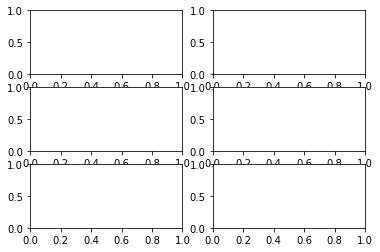

In [6]:
stru = ['Hpc','BLA','Pir']
# stru = ['CeCM']
fig,ax = plt.subplots(3,2)
for i,s in enumerate(stru):
    print('NREM ' + s)
    plot_firing_pre_post_sleep(merged_sws,s,'Pyr',ax[i,0])
    print('REM ' + s)
    plot_firing_pre_post_sleep(merged_rem,s,'Pyr',ax[i,1])

In [3]:
discard = [
    "Rat08-20130718",
    "Rat09-20140408",
    "Rat09-20140409",
    "Rat10-20140619",
    "Rat10-20140620",
    "Rat10-20140622",
]


In [5]:
args = ['sws']
df = bk.load.batch(main,*args,verbose = False)
merged_sws = merge(df,'sws',discard)

100%|██████████| 61/61 [01:05<00:00,  1.08s/it]

Batch finished in 65.98207879066467
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130709', 'Rat08-20130710', 'Rat08-20130711', 'Rat08-20130712', 'Rat08-20130713', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130717', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140325', 'Rat09-20140326', 'Rat09-20140327', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140622', 'Rat10-20140624', 'Rat10-20140626', 'Rat10-20140627', 'Rat10-20140628', 'Rat10-20140629', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150321', 'Ra

ValueError: need at least one array to concatenate

In [6]:
args = ['Rem']
df = bk.load.batch(main,*args,verbose = False)
merged_rem = merge(df,'Rem',discard)

 33%|███▎      | 20/61 [00:24<00:43,  1.07s/it]

Loading Data from Rat09-20140401
Rat : 9 on day : 8
Working with session Rat09-20140401 @ /home/billel/Data/GG-Dataset/Rat09/Rat09-20140401
Data already saved in Numpy format, loading them from here:
Rat09-20140401-neurons.npy


In [ ]:
args = ['wake']
df = bk.load.batch(main,*args,verbose = False)
merged_wake = merge(df,'wake',discard)

100%|██████████| 61/61 [02:39<00:00,  2.62s/it]

Batch finished in 159.5758593082428
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130709', 'Rat08-20130710', 'Rat08-20130712', 'Rat08-20130713', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140325', 'Rat09-20140326', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140405', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140626', 'Rat10-20140627', 'Rat10-20140629', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150315', 'Rat11-20150323', 'Rat11-20150327', 'Rat11-20150330', 'Rat11-20150331', 'Rat11-20150401']
54.09836065573771 %


In [ ]:
%matplotlib qt
plot_firing_pre_post_sleep(merged_sws,'BLA','Pyr')
plot_firing_pre_post_sleep(merged_rem,'BLA','Pyr')

NameError: name 'plot_firing_pre_post_sleep' is not defined

# Across Time

Here I will try to reproduce Miyawaki2016 / Torrado2021 analysis in which they show the average FR across sleep

In [26]:
def debug(base_folder,local_path,*args,**kwargs):
    bk.load.current_session_linux(base_folder,local_path)
    states = bk.load.states()

    extended_wake = get_extended(states, 'wake', 60, 60*30)
    # extended_wake = get_extended(states, 'wake', 60*30, 60)

    plt.figure()
    bk.plot.intervals(extended_wake,'red')
    bk.plot.intervals(states['sws'],'grey')
    bk.plot.intervals(states['Rem'],'orange')



100%|██████████| 61/61 [00:02<00:00, 20.86it/s]

Batch finished in 2.930429697036743
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat11-20150402', 'Rat11-20150403']
11.475409836065573 %


({'Rat08-20130708': None,
  'Rat08-20130709': None,
  'Rat08-20130710': None,
  'Rat08-20130711': None,
  'Rat08-20130712': None,
  'Rat08-20130713': None,
  'Rat08-20130715': None,
  'Rat08-20130716': None,
  'Rat08-20130717': None,
  'Rat08-20130718': None,
  'Rat08-20130719': None,
  'Rat09-20140324': None,
  'Rat09-20140325': None,
  'Rat09-20140326': None,
  'Rat09-20140327': None,
  'Rat09-20140328': None,
  'Rat09-20140329': None,
  'Rat09-20140331': None,
  'Rat09-20140401': None,
  'Rat09-20140402': None,
  'Rat09-20140403': None,
  'Rat09-20140404': None,
  'Rat09-20140405': None,
  'Rat10-20140619': None,
  'Rat10-20140620': None,
  'Rat10-20140622': None,
  'Rat10-20140624': None,
  'Rat10-20140626': None,
  'Rat10-20140627': None,
  'Rat10-20140628': None,
  'Rat10-20140629': None,
  'Rat10-20140701': None,
  'Rat10-20140702': None,
  'Rat10-20140703': None,
  'Rat10-20140704': None,
  'Rat10-20140705': None,
  'Rat10-20140707': None,
  'Rat10-20140708': None,
  'Rat11-201

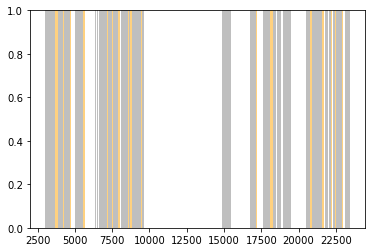

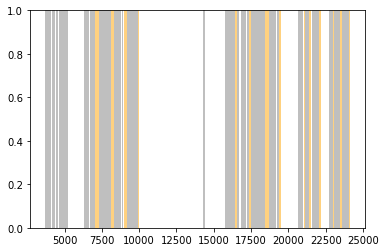

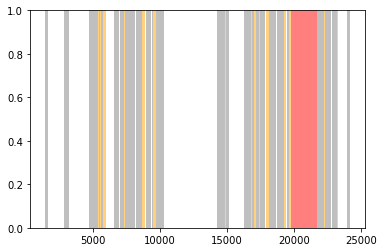

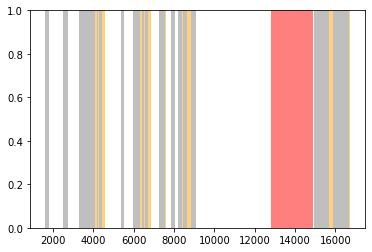

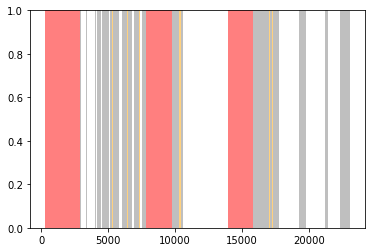

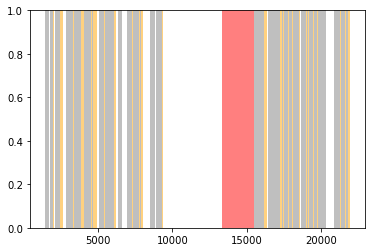

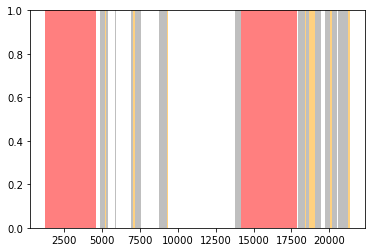

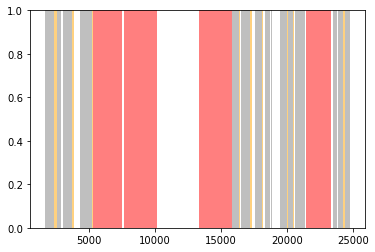

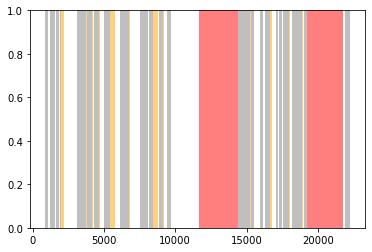

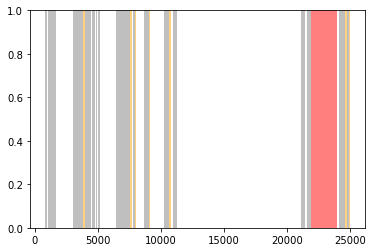

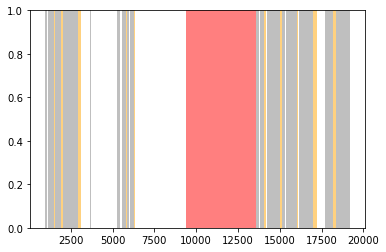

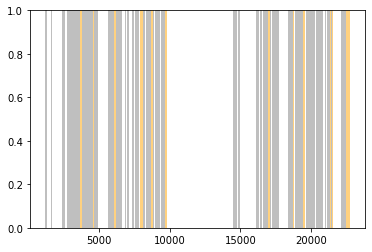

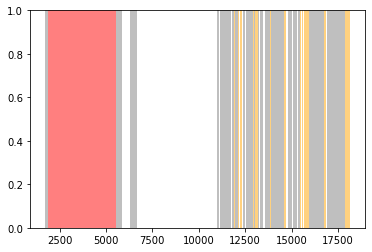

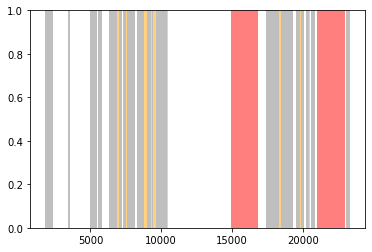

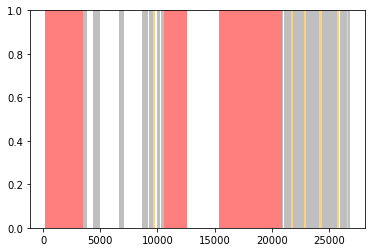

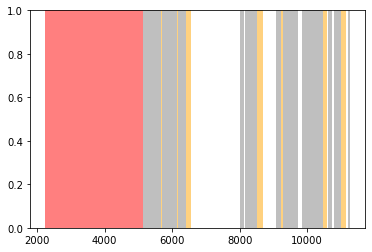

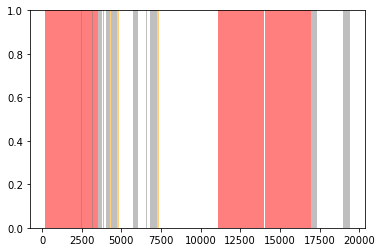

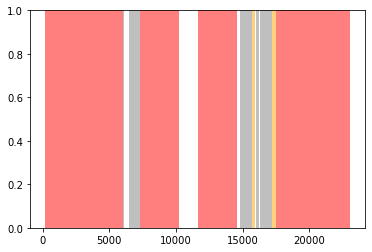

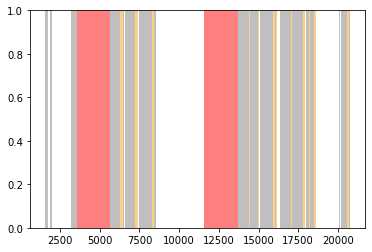

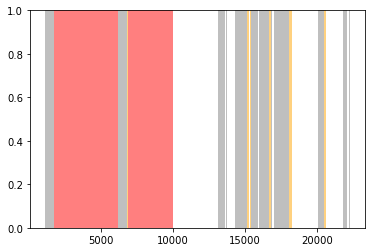

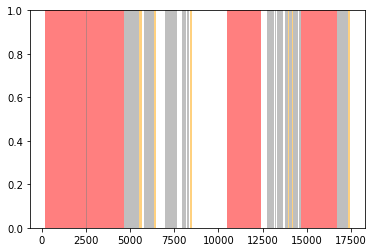

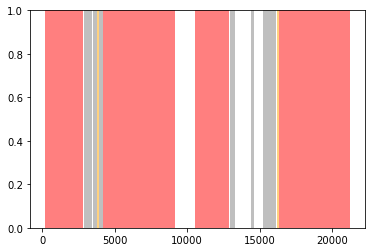

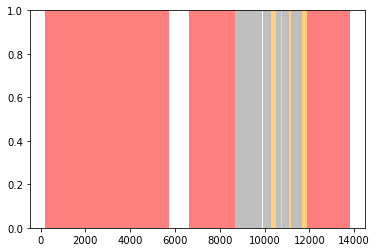

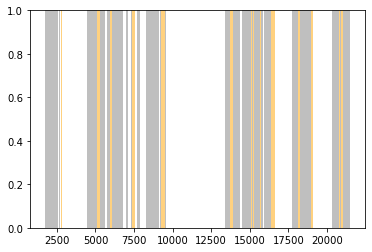

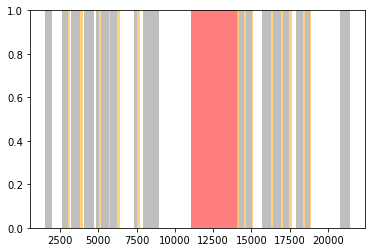

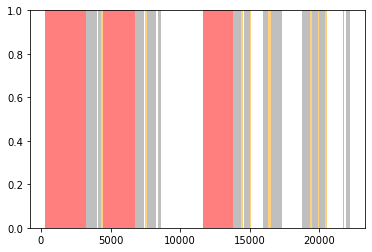

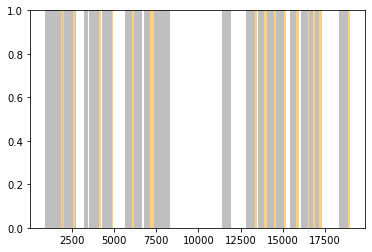

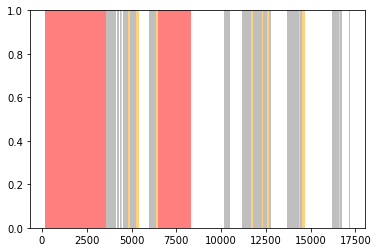

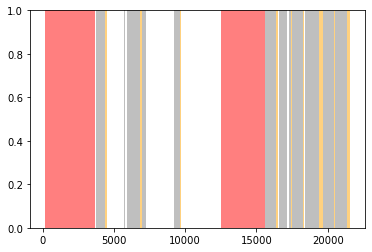

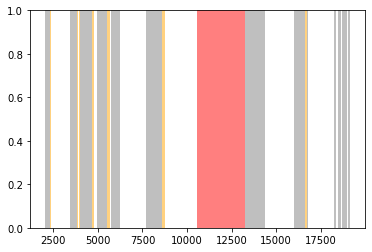

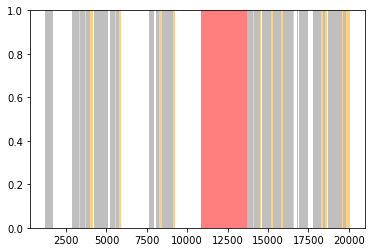

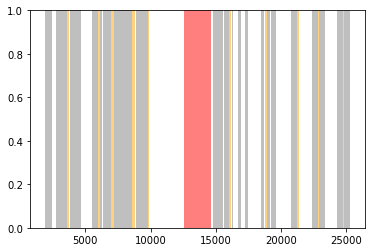

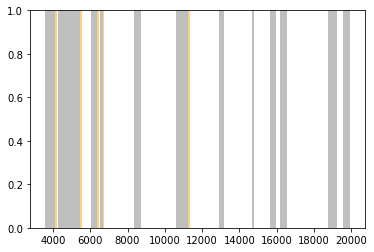

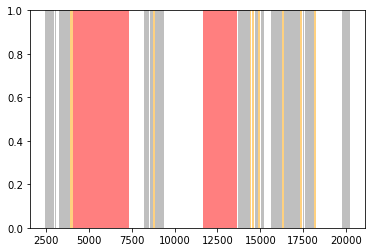

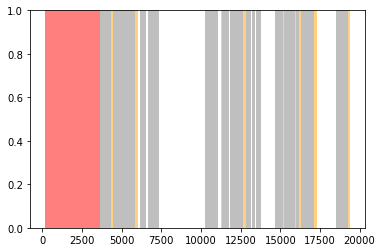

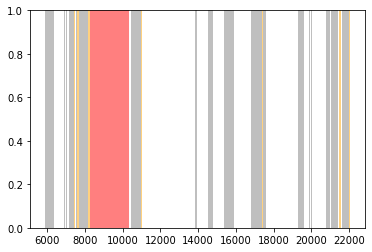

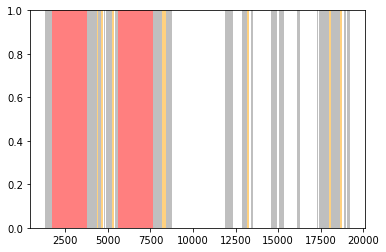

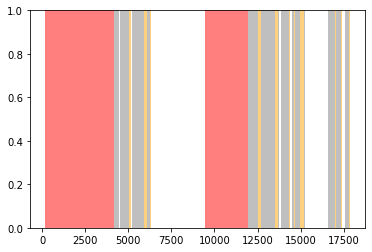

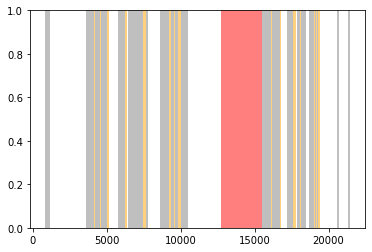

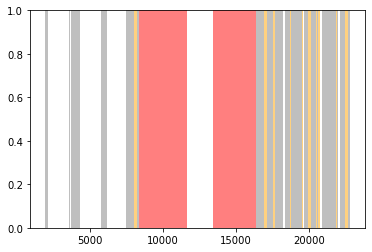

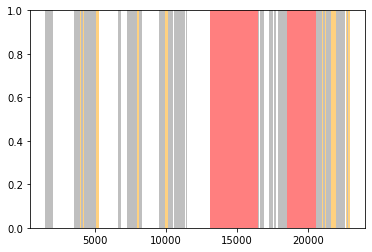

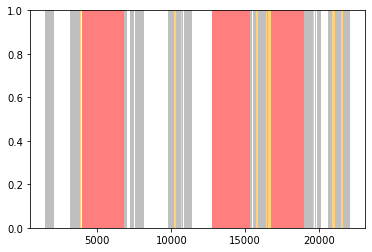

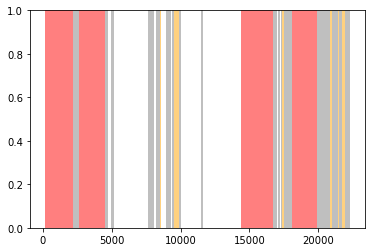

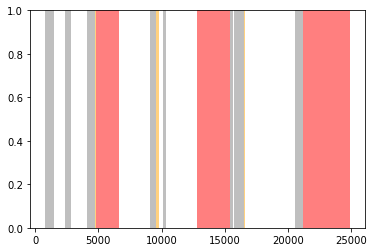

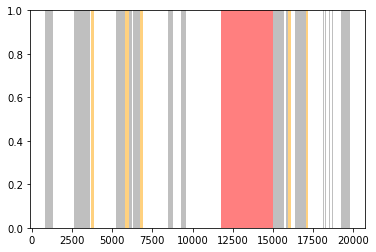

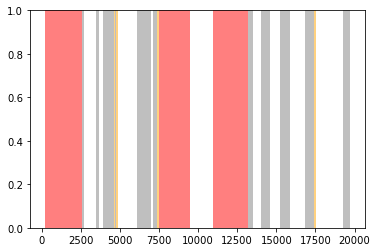

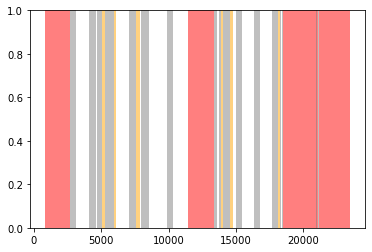

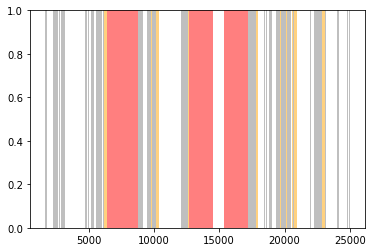

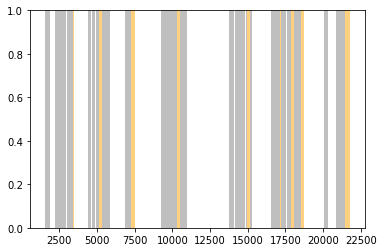

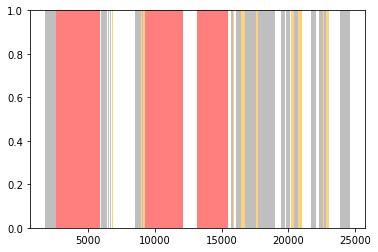

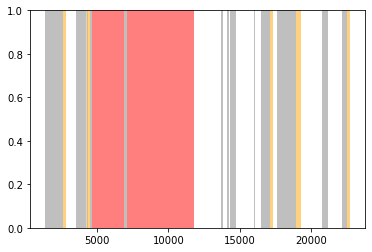

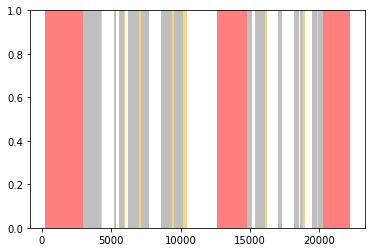

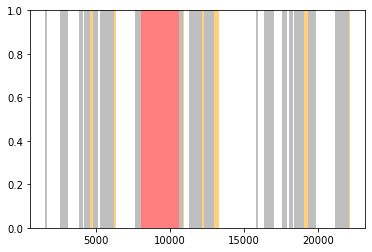

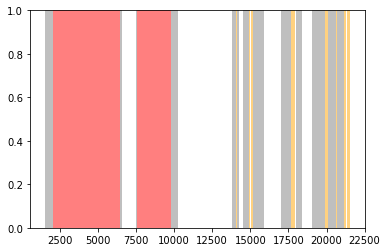

In [27]:
bk.load.batch(debug)

In [8]:
def tsd_zscore(tsd, axis=0):
    from scipy.stats import zscore
    t = tsd.index.values
    q = zscore(tsd.values, axis=axis)

    return nts.TsdFrame(t, q)


def get_extended(states, state='sleep', sleep_th=60*30, wake_th=60):

    # Return extended sleep session given state, sleep
    if state.lower() == 'sleep':
        extended = states['sws'].union(
            states['Rem']).merge_close_intervals(wake_th, time_units='s')
        extended = extended[extended.duration(
            time_units='s') > sleep_th].reset_index(drop=True)

    elif state.lower() == 'wake':
        extended = states['wake_homecage'].merge_close_intervals(
            sleep_th, time_units='s')
        extended = extended[extended.duration(
            time_units='s') > wake_th].reset_index(drop=True)
    return extended


def main(base_folder, local_path, *args, **kwargs):

    binSize = kwargs['binSize']

    bk.load.current_session_linux(local_path=local_path)
    states = bk.load.states()
    neurons, metadata = bk.load.spikes()

    z_fr_across_extended = {}

    extended_sleep = get_extended(states, 'sleep', 60*30, 60)

    for state in ['sws', 'Rem']:
        ext_sleep_b = []
        for s, e in extended_sleep.as_units('s').iloc:
            t, b = bk.compute.binSpikes(neurons, binSize, s, e)
            b = nts.TsdFrame(t, b.T, 's')
            b = tsd_zscore(b).restrict(states[state])
            b.index = b.index - s*1_000_000
            ext_sleep_b.append(b)

        z_fr_across_extended.update({state: ext_sleep_b})

    extended_wake = get_extended(states, 'wake', 60, 60*30) #FIXME : Check if this make sens by plotting them :) Should be ok this way. 
    ext_wake_b = []
    for s, e in extended_wake.as_units('s').iloc:
        t, b = bk.compute.binSpikes(neurons, binSize, s, e)
        b = nts.TsdFrame(t, b.T, 's')
        b = tsd_zscore(b)
        b.index = b.index - s*1_000_000
        ext_wake_b.append(b)
    z_fr_across_extended.update({'wake': ext_wake_b})

    return z_fr_across_extended, metadata


def merge(batch, stru='BLA', type = 'Pyr'):
    merged_all = {}
    for state in ['sws', 'Rem', 'wake']:
        merged = []
        for i, (ext, metadata) in batch.items():
            if np.any((metadata.Region == stru) & (metadata.Type == type)):
                for j in ext[state]:
                    if np.any(np.isfinite(j.values[:, (metadata.Region == stru) & (metadata.Type == type)])):
                        # add -j.index.values[-1] if we want to plot by the end of extsleep
                        merged.append(nts.TsdFrame(j.index.values, np.nanmean(
                            j.values[:, (metadata.Region == stru) & (metadata.Type == type)], 1)))
                    # merged.append(nts.TsdFrame(j.index.values,j.values))
        merged = pd.concat(merged, axis=1)
        merged.columns = range(merged.columns.size)
        merged_all.update({state: merged})
    return merged_all


def compute_linreg(merged, time_units='s'):
    t = []
    v = []
    for i in merged:
        t.append(merged.as_units(time_units).index.values)
        v.append(merged[i].values)

    t = np.array(t)
    v = np.array(v)

    t_clean = t[np.isfinite(v)]
    v_clean = v[np.isfinite(v)]
    reg = scipy.stats.linregress(t_clean, v_clean)
    print(reg)
    return reg


def plot_ext_sleep_fr(merged, reg, color='grey', s=5, ax=None):
    
    ext_sess = merged.shape[1]
    
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    plt.sca(ax)
    for i in merged:
        plt.scatter(merged.as_units('s').index.values,
                    merged[i].values, facecolor=color, s=s, alpha=0.5)
    x = np.arange(0, np.max(merged.as_units('s').index.values))
    y = x * reg.slope + reg.intercept


    

    ax.plot(x, y, 'red')
    ax.set_title(f'{stru} - {state} - {ext_sess}')
    ax.set_ylabel('Firing Rates (Zscore)')
    ax.set_xlabel('Time From Extended Sleep (s)')
    ax.set_ylim(-2, 2)
    # ax.set_xlim(0, x[-1])


    ax.text(50,-1.5,f'pValue : {reg.pvalue:.2f} \nrValue : {reg.rvalue:.2f}')
    

    plt.tight_layout()


In [9]:
binSize = 30
kwargs = {
    'binSize':binSize,
}
batch = bk.load.batch(main, verbose=False, **kwargs) 

100%|██████████| 61/61 [01:50<00:00,  1.81s/it]

Batch finished in 110.67812991142273
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat11-20150402', 'Rat11-20150403']
11.475409836065573 %


LinregressResult(slope=-5.096167778237744e-05, intercept=0.05455834827759087, rvalue=-0.17695657159990347, pvalue=7.382156661371237e-18, stderr=5.872062324201732e-06, intercept_stderr=0.009712942469968422)


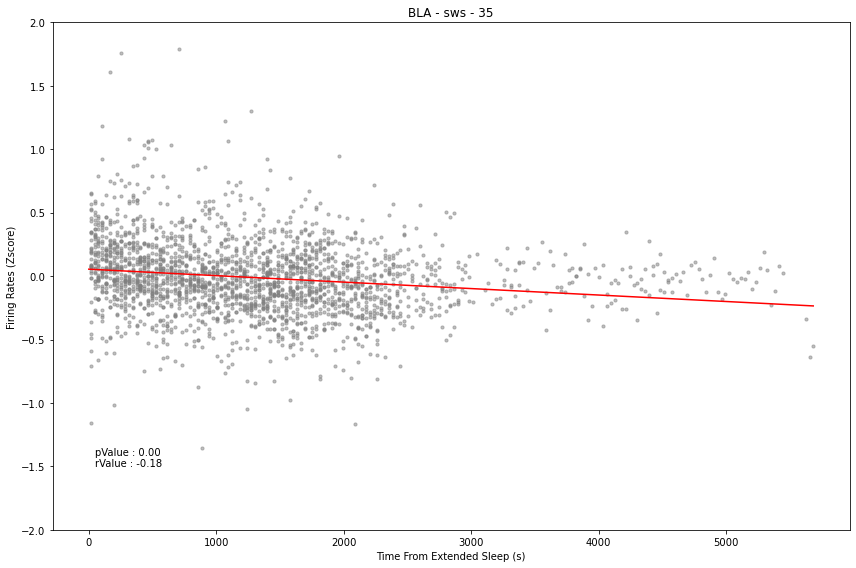

In [4]:
stru = 'BLA'
state = 'sws'
color = 'grey'

merged = merge(batch[0], stru,'Pyr')
reg = compute_linreg(merged[state])
plot_ext_sleep_fr(merged[state], reg, color, 10)

Hpc sws
LinregressResult(slope=-5.088411754481624e-05, intercept=0.10259287669567274, rvalue=-0.13402228730827728, pvalue=4.2593956253854036e-09, stderr=8.622553585399943e-06, intercept_stderr=0.01273891678975647)
Hpc Rem
LinregressResult(slope=4.5524416581387766e-05, intercept=-0.18823347171053986, rvalue=0.07136879269890323, pvalue=0.1332237767373081, stderr=3.026328286378287e-05, intercept_stderr=0.04985629940280313)
Hpc wake
LinregressResult(slope=2.049262118536103e-06, intercept=-0.013223719418042637, rvalue=0.028908263395914995, pvalue=9.052403801490176e-06, stderr=4.615843004995974e-07, intercept_stderr=0.003931046030114516)
BLA sws
LinregressResult(slope=-5.096167778237744e-05, intercept=0.05455834827759087, rvalue=-0.17695657159990347, pvalue=7.382156661371237e-18, stderr=5.872062324201732e-06, intercept_stderr=0.009712942469968422)
BLA Rem
LinregressResult(slope=-1.401109216929754e-05, intercept=0.13333401317839058, rvalue=-0.027433929193880015, pvalue=0.5487774940749195, std

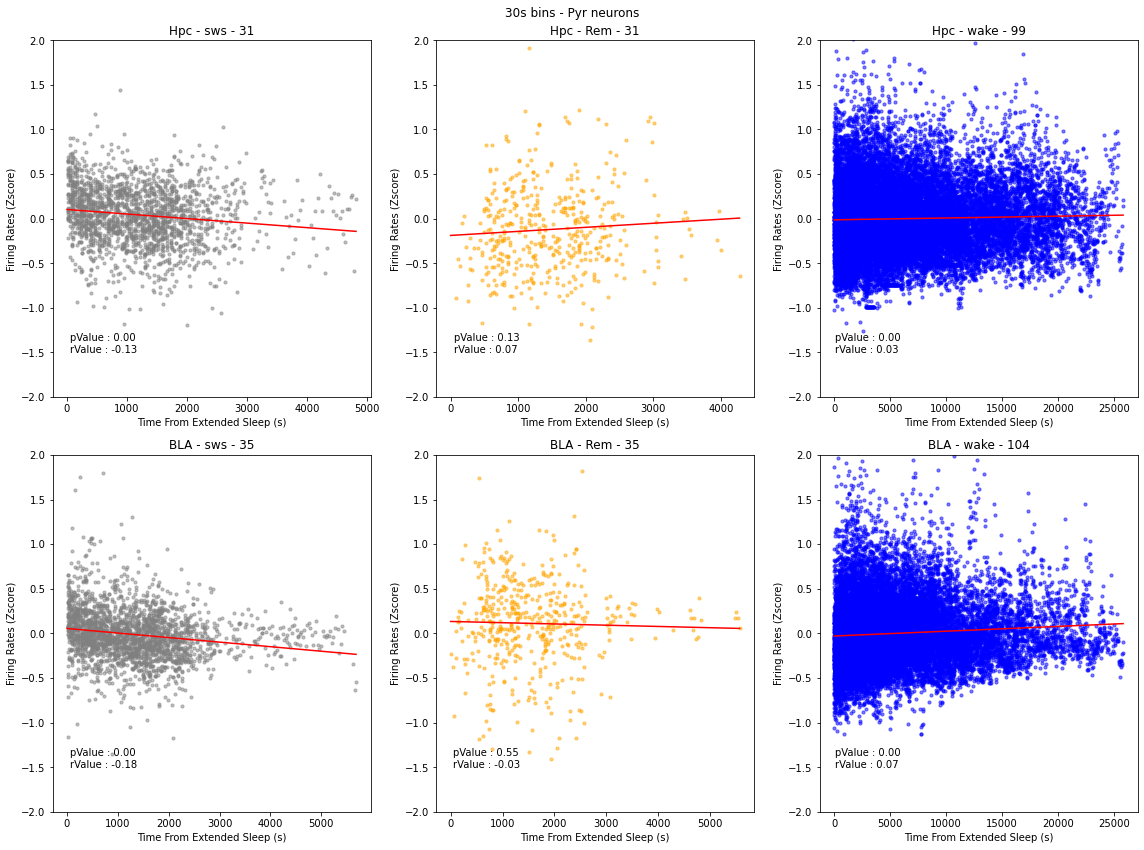

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12))
# structures = ['Hpc', 'BLA', 'CeCM', 'Pir','DEn','LaDL','CPu']
structures = ['Hpc','BLA']
states = ['sws', 'Rem','wake']
colors = ['grey', 'orange','blue']


for i, stru in enumerate(structures):
    for j, (state, c) in enumerate(zip(states, colors)):
        print(stru, state)
        merged = merge(batch[0], stru,'Pyr')
        reg = compute_linreg(merged[state])
        plot_ext_sleep_fr(merged[state], reg, c, 10, ax[i, j])
plt.suptitle('30s bins - Pyr neurons')
plt.tight_layout()
# plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Firing_Across_Sleep/firing_across_sleep.svg')

/tmp/ipykernel_192836/2469364104.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


IndexError: index 32 is out of bounds for axis 1 with size 32

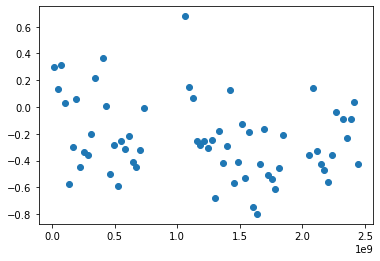

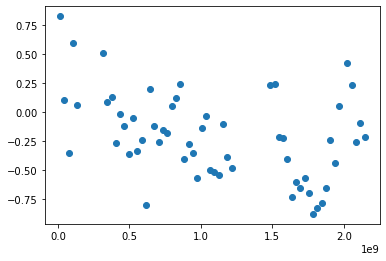

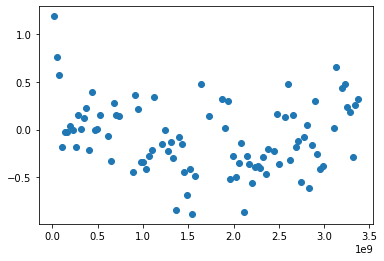

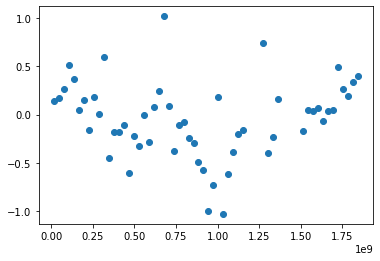

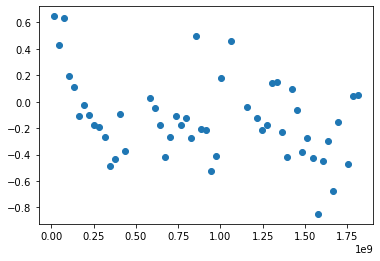

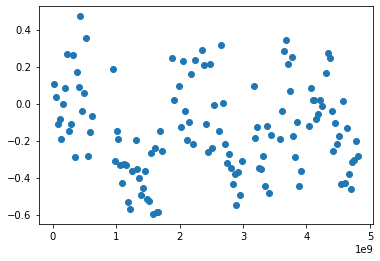

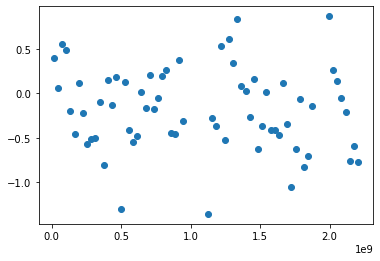

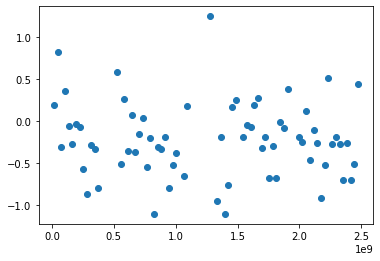

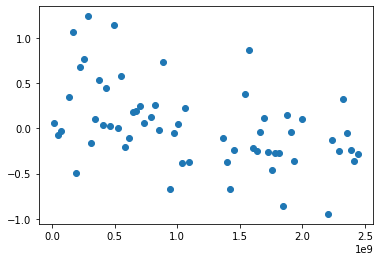

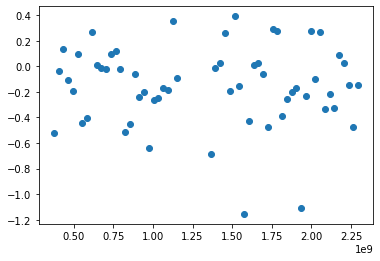

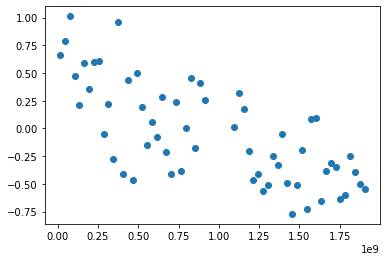

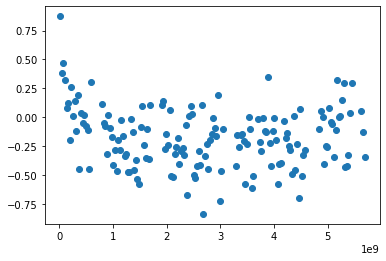

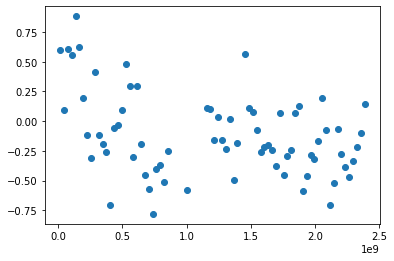

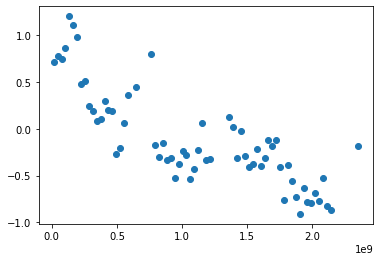

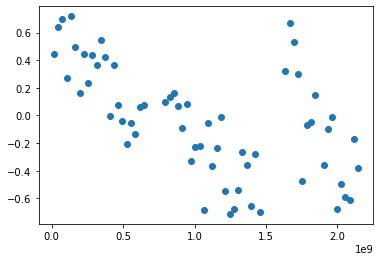

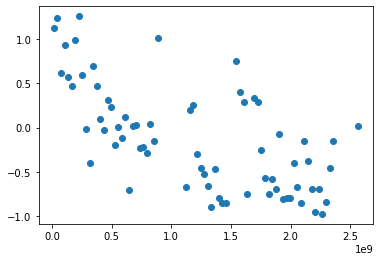

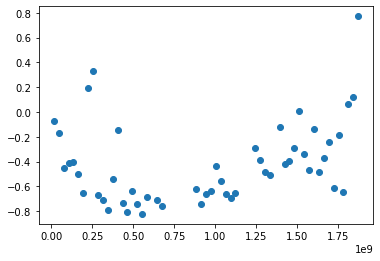

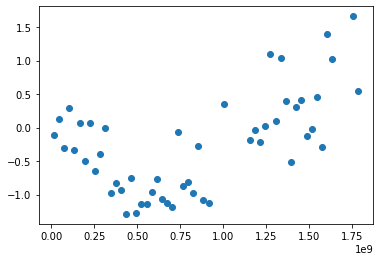

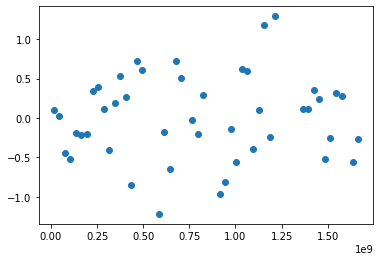

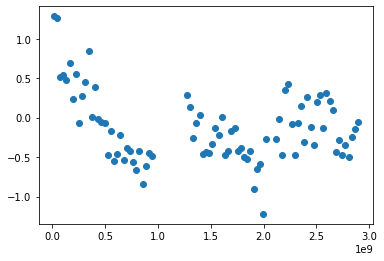

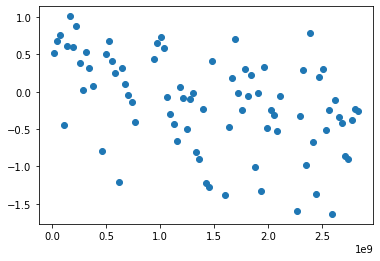

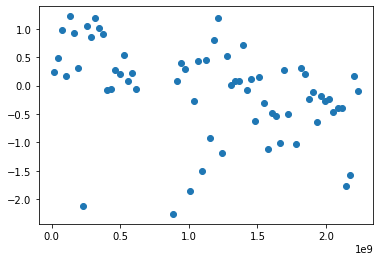

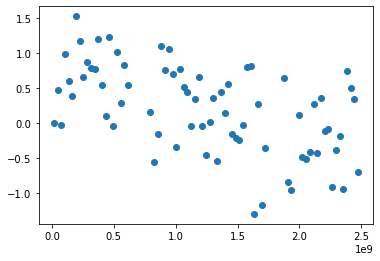

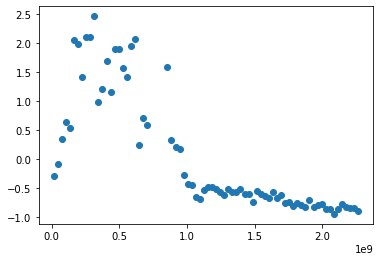

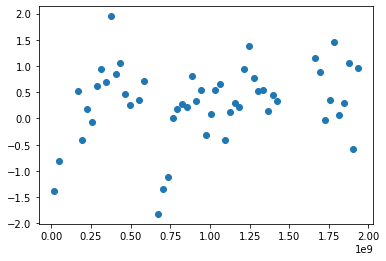

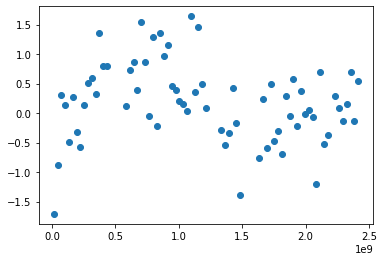

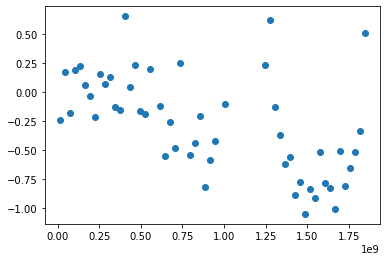

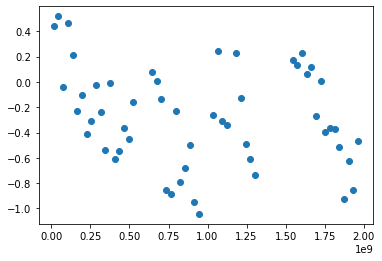

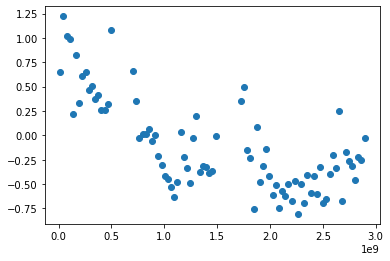

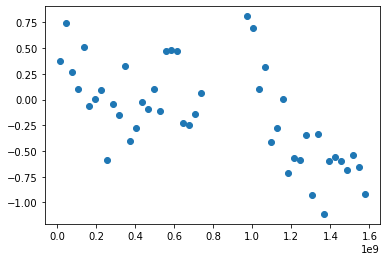

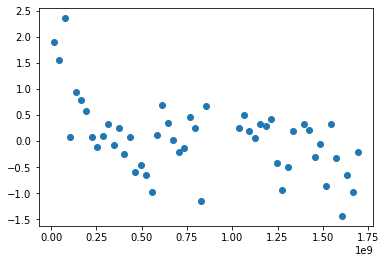

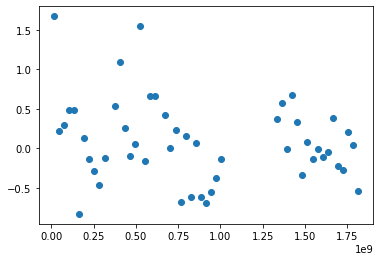

<Figure size 432x288 with 0 Axes>

In [71]:
merged = merge(batch[0], 'BLA','Int')
for i in range(35):
    plt.figure()
    plt.scatter(merged['sws'].index.values,merged['sws'].values[:,i])